# Analysis app_events (+labels, categories)

In [1]:
import os
import math

import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline

dir_in = './data_ori/'
dir_Out = './data/'

In [ ]:
def is_weekend(day_of_week):
    if day_of_week in []:
        return 1
    return 0

def is_during_day(hour_of_day):
    if hour_of_day>7 or hour_of_day>18:
        return 0
    

In [2]:
# Load app_events
print('Reading events...')
events = pd.read_csv(dir_in + 'events.csv')

events['timestamp'] = pd.to_datetime(events['timestamp'])
events['timestamp_h'] = events['timestamp'].dt.hour
events['timestamp_d'] = events['timestamp'].dt.day
events.timestamp_d[events['timestamp_d']==30] = 0
events['timestamp_hd'] = events['timestamp_h']/2.4 + events['timestamp_d']*10

Reading events...


/Users/guusjeschouten/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
events.head(10)

,event_id,device_id,timestamp,longitude,latitude,timestamp_h,timestamp_d,timestamp_hd
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,0,1,10.0
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,0,1,10.0
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,0,1,10.0
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,0,1,10.0
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,0,1,10.0
5,6,1476664663289716375,2016-05-01 00:27:21,0.00,0.00,0,1,10.0
6,7,5990807147117726237,2016-05-01 00:15:13,113.73,23.00,0,1,10.0
7,8,1782450055857303792,2016-05-01 00:15:35,113.94,34.70,0,1,10.0
8,9,-2073340001552902943,2016-05-01 00:15:33,0.00,0.00,0,1,10.0
9,10,-8195816569128397698,2016-05-01 00:41:31,119.34,26.04,0,1,10.0


## Total number of events

In [4]:
number_of_events = events.groupby('device_id').size()
number_of_events.sort_values(ascending=False).head()

device_id
 1186608308763918427    33426
 3915082290673137129    14568
-1656894751624916732     6731
-6242501228649113250     4150
-8340098378141155823     3973
dtype: int64

(0, 500)

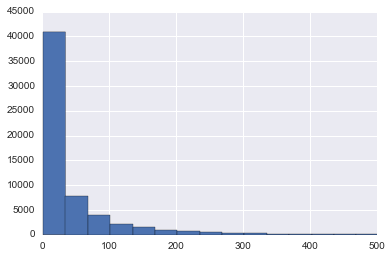

In [5]:
number_of_events.hist(bins=1000)
plt.xlim([0,500])

Preferably four different counts:
1. per category sum(is_installed) totals
2. per category sum(is_installed) relative to total installed
3. per category sum(is_active) totals
4. per category sum(is_active) relative to total_active
5. per category is app category installed
6. per category is app category active

In [48]:
# 1:
df1 = app_events.reset_index().groupby(['event_id']).sum()
df1.head(5)

,app_id,is_installed,is_active,1 free,1 reputation,1 vitality,3 kindom game,80s Japanese comic,90s Japanese comic,A beauty care,...,travel,tribe,trickery,unknown,video,violence comic,vitality,war chess,weibo,zombies game
event_id,,,,,,,,,,,,,,,,,,,,,
2,2.805985e+19,19.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.039371e+19,38.0,15.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0
7,2.623446e+19,40.0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0
9,2.739554e+19,35.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0
16,2.464116e+19,31.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,2.0,0.0


In [49]:
# 2:
df2 = app_events.reset_index().groupby(['event_id']).sum()
df2[app_cat_col] = df2[app_cat_col].div(df['is_installed'], axis=0)
df2.head(5)

,app_id,is_installed,is_active,1 free,1 reputation,1 vitality,3 kindom game,80s Japanese comic,90s Japanese comic,A beauty care,...,travel,tribe,trickery,unknown,video,violence comic,vitality,war chess,weibo,zombies game
event_id,,,,,,,,,,,,,,,,,,,,,
2,2.805985e+19,19.0,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.052632,0.0,0.0,0.263158,0.000000,0.0,0.0,0.0,0.000000,0.0
6,3.039371e+19,38.0,15.0,0.078947,0.026316,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.236842,0.052632,0.0,0.0,0.0,0.000000,0.0
7,2.623446e+19,40.0,13.0,0.050000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.125000,0.025000,0.0,0.0,0.0,0.025000,0.0
9,2.739554e+19,35.0,7.0,0.085714,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.171429,0.085714,0.0,0.0,0.0,0.000000,0.0
16,2.464116e+19,31.0,1.0,0.161290,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.258065,0.096774,0.0,0.0,0.0,0.064516,0.0


In [50]:
# 3:
df3 = app_events[app_events.is_active==1].reset_index().groupby(['event_id']).sum()
df3.head(5)

,app_id,is_installed,is_active,1 free,1 reputation,1 vitality,3 kindom game,80s Japanese comic,90s Japanese comic,A beauty care,...,travel,tribe,trickery,unknown,video,violence comic,vitality,war chess,weibo,zombies game
event_id,,,,,,,,,,,,,,,,,,,,,
2,3.140823e+19,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.696323e+19,15.0,15.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
7,-7.023240e+18,13.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
9,2.587383e+19,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,5.516228e+18,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# 4:
df4 = app_events[app_events.is_active==1].reset_index().groupby(['event_id']).sum()
df4[app_cat_col] = df4[app_cat_col].div(df['is_active'], axis=0)
df4.head(5)

,app_id,is_installed,is_active,1 free,1 reputation,1 vitality,3 kindom game,80s Japanese comic,90s Japanese comic,A beauty care,...,travel,tribe,trickery,unknown,video,violence comic,vitality,war chess,weibo,zombies game
event_id,,,,,,,,,,,,,,,,,,,,,
2,3.140823e+19,6.0,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
6,2.696323e+19,15.0,15.0,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.200000,0.066667,0.0,0.0,0.0,0.000000,0.0
7,-7.023240e+18,13.0,13.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.153846,0.000000,0.0,0.0,0.0,0.076923,0.0
9,2.587383e+19,7.0,7.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
16,5.516228e+18,1.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


In [135]:
#5
df5 = app_events[app_events.is_active==1].reset_index().groupby(['event_id']).sum()
df5[app_cat_col] = (df5[app_cat_col]>0).astype(int)
df5.head()

,app_id,is_installed,is_active,1 free,1 reputation,1 vitality,3 kindom game,80s Japanese comic,90s Japanese comic,A beauty care,...,travel,tribe,trickery,unknown,video,violence comic,vitality,war chess,weibo,zombies game
event_id,,,,,,,,,,,,,,,,,,,,,
2,3.140823e+19,6.0,6.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2.696323e+19,15.0,15.0,1,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
7,-7.023240e+18,13.0,13.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
9,2.587383e+19,7.0,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,5.516228e+18,1.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
# 3:
df6 = app_events[app_events.is_active==1].reset_index().groupby(['event_id']).sum()
df6[app_cat_col] = (df6[app_cat_col]>0).astype(int)
df6.head(5)

,app_id,is_installed,is_active,1 free,1 reputation,1 vitality,3 kindom game,80s Japanese comic,90s Japanese comic,A beauty care,...,travel,tribe,trickery,unknown,video,violence comic,vitality,war chess,weibo,zombies game
event_id,,,,,,,,,,,,,,,,,,,,,
2,3.140823e+19,6.0,6.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2.696323e+19,15.0,15.0,1,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
7,-7.023240e+18,13.0,13.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
9,2.587383e+19,7.0,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,5.516228e+18,1.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Merge with devices

In [66]:
print('Loading train and event data')
train = pd.read_csv(dir_in + 'gender_age_train.csv', dtype={'device_id':np.str})
event = pd.read_csv(dir_in + 'events.csv', dtype={'device_id':np.str})

Loading train and event data


In [67]:
print('Size event:', df1.shape)
print('Size df1:', event.shape)
print('Size train:', train.shape)
event_app = pd.merge(event, df1, how='inner', left_on='event_id',right_index=True)
event_app = pd.merge(event_app, train, how='inner', on='device_id')
print('Size after merge:', event_app.shape)

('Size event:', (3553, 476))
('Size df1:', (3252950, 5))
('Size train:', (74645, 4))
('Size after merge:', (1336, 484))


In [68]:
event_app.groupby('device_id').size().sort_values(ascending=False).head()

device_id
3074308677943390456     21
1057289835566390654      5
-4483235488687461351     4
2526025498254449332      4
4657697113512107583      3
dtype: int64

In [88]:
summary = event_app.groupby(['gender','device_id']).mean().unstack('gender')
summary.drop(['event_id','longitude','latitude','app_id'],axis=1, inplace=True)
print summary.head()

                     is_installed       is_active       1 free       \
gender                          F     M         F     M      F    M   
device_id                                                             
-1032555705119615296          9.0   NaN       9.0   NaN    0.0  NaN   
-1037012685448076071          NaN  63.0       NaN   2.0    NaN  4.0   
-1084174363886138500          NaN  20.5       NaN   9.5    NaN  1.0   
-1086079967197442674          NaN   8.0       NaN   8.0    NaN  0.5   
-1104601348418161884          NaN  56.5       NaN  20.5    NaN  5.0   

                     1 reputation      1 vitality       ...  vitality       \
gender                          F    M          F    M  ...         F    M   
device_id                                               ...                  
-1032555705119615296          0.0  NaN        0.0  NaN  ...       0.0  NaN   
-1037012685448076071          NaN  0.0        NaN  0.0  ...       NaN  0.0   
-1084174363886138500          NaN  0.5   

In [96]:
is_ins = summary.is_installed.sum()
is_act = summary.is_active.sum()

print is_ins / max(is_ins)
print is_act / max(is_act)

gender
F    0.279251
M    1.000000
dtype: float64
gender
F    0.381879
M    1.000000
dtype: float64


In [128]:
summary.sum().unstack('gender').sort_values('F',ascending=False).head()

gender,F,M
age,10832.000000,28758.000000
is_installed,7349.750000,26319.533333
Industry tag,5495.083333,19446.450000
Property Industry 2.0,3879.750000,13542.950000
Property Industry 1.0,3121.166667,10847.666667
